# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [1]:
# Imports

import calendar
from datetime import datetime
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import sys
import xlrd

- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

In [2]:
class Neiss:
    DICT_CATEGORY_TRANSLATOR = {}

    def __init__(self, df):
        self.df = df
        #self.df['Age'] = self.translateAge(self.df['Age'])

    def setColumnCodeDictionary(column_dictionary):
        Neiss.DICT_CATEGORY_TRANSLATOR = column_dictionary
        
    def getDataFrame(self):
        return self.df

    def getColumnDictionary(column_name):
        return Neiss.DICT_CATEGORY_TRANSLATOR[column_name]


    def extractRowsWhereColumnContainsString(self, column_name, search_values, case=False, translate_codes=False):
        '''
        Search the column specified by column_name for the strings listed in search_values.
        Args:
            column_name (str): The name of the column to search for the strings
            search_values (list): A list containing the strings to search for
            
        Return:
            A dataframe containing the rows where the search was successful
        '''
        # https://kanoki.org/2019/03/27/pandas-select-rows-by-condition-and-string-operations/
        
        
        df = self.df[self.df[column_name].str.contains('|'.join(search_values), case=case)]
        if True == translate_codes:
            df = Neiss.translateCodes(df)
        return df
    
    def extractRowsWhereColumnsContainCode(self, column_names, search_values, translate_codes=False):
        '''
        Search the column specified by column_name for the strings listed in search_values.
        Args:
            column_names (list(str)): Alist containing the names of columns to search for the strings
            search_values (list): A list containing the codes to search for
            
        Return:
            A dataframe containing the rows where the search was successful
        '''
        df = pd.DataFrame()
        for column_name in column_names:
            df_filter = self.df[column_name].isin(search_values)
            if df.empty:
                df = self.df[df_filter]
            else:
                df.append(self.df[df_filter])

        if True == translate_codes:
            df = Neiss.translateCodes(df)
        return df

    def lookupCodeFor(category, lookup_name):
        inverse = {v: k for k, v in Neiss.DICT_CATEGORY_TRANSLATOR[category].items()}
        return inverse[lookup_name]
    
    def translateAge(self, df):
        return [age if age < 200 else (age - 200)/12 for age in df['Age']]

    def translateCodes(df):
        return df.replace( Neiss.DICT_CATEGORY_TRANSLATOR)



## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [3]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    neiss_df = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET CS677 - Data Science with Python/Project/data/NEISS/neiss_data.pckl  ... done!


In [4]:
neiss_df.shape


(7352927, 19)

In [5]:
neiss_df.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,100001,1999-12-24,41,2,1.0,0,31,71,NaN,1,0,0,3299,0,41 YR FEMALE FELL WHILE WALKING. DX: SEVERE MU...,/RIGHT BUTTOCKS & BACK.,S,71,68.1086
1,100002,1999-12-27,80,1,2.0,0,31,57,NaN,1,0,0,611,0,80 YR MALE FELL IN BATHROOM/HE HIT RIGHT RIBS ...,DX: FRACTURED RIGHT RIBS-UPPER TRUNK,S,71,68.1086
2,100003,1999-12-27,4,1,1.0,0,75,53,NaN,1,0,0,1328,0,4 YR MALE HAD METAL LARGE WAGON WHEEL FALL & H...,DX: CONTUSIN ON HEAD/NO LOC.,S,71,68.1086
3,100005,1999-12-28,18,1,0.0,NaN,94,53,NaN,1,0,0,1205,0,CONTUSION EAR - STRUCK IN RIGHT EAR WITH BASKE...,NaN,S,7,68.1086
4,100009,1999-12-28,19,2,0.0,NaN,92,64,NaN,1,0,0,5031,0,SPRAIN THUMB - INJURED THUMB WHEN SNOWBOARDING,NaN,S,7,68.1086


In [6]:
def getColumnCodeDictionary(fname):
    d1 = {}
    with xlrd.open_workbook(fname) as workbook:
        sheet_names = workbook.sheet_names()

        for sheet in sheet_names:
            xl_sheet = workbook.sheet_by_name(sheet)

            d2 = {}
            for row_idx in range(0, xl_sheet.nrows):
                code = int(xl_sheet.cell_value(row_idx, 0))
                value = xl_sheet.cell_value(row_idx, 1)
                d2[code] = value
            d1[sheet] = d2
    return d1

column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [7]:
neiss = Neiss(neiss_df)

## Generates a graph showing injuries per year

In [8]:
def showInjuriesPerYear(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number of injuries per year
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_year'] = [t.year for t in df2[date_name]]

    df3 = pd.pivot_table(
        df2, values='_count', index=['_year'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)

    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Year')

## Generates a graph showing injuries per week (1 ... 52) of the year

In [9]:
def showInjuriesPerWeekOfTheYear(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number of injuries week within the year
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_week'] = [t.week for t in df2[date_name]]

    df3 = pd.pivot_table(
        df2, values='_count', index=['_week'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)

    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Week Of The Year')
    ax.set_xticks(range(1,52))


## Generates a graph of aggregated injuries per month

In [10]:
def showInjuriesPerMonthOfTheYear(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number per month
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_month'] = [t.month for t in df2[date_name]]
    
    
    df3 = pd.pivot_table(
        df2, values='_count', index=['_month'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)
    df3.index = calendar.month_name[1:]

    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Month')

## Generates a graph a graph of aggregated injuries per weekday

In [11]:
def showInjuriesPerWeekOfTheYear(df, date_name, stat_name, sup_title):
    '''
    Show the accumulated number per weekday
    
    Args:
        date_name (str): The name of the column containing the datetime instances
        stat_name (str): The name of the column to include in the graph (one line per unique item will be displayed)
        sup_title (str): The super position title to display
    
    Returns:
        None
    '''
    stat_dict = Neiss.getColumnDictionary(stat_name)

    df1 = df.xs([stat_name, date_name], axis='columns')
    df2 = df1.copy()
    df2['_count'] = 1
    df2['_week_day'] = [t.weekday() for t in df2[date_name]]

    df3 = pd.pivot_table(
        df2, values='_count', index=['_week_day'], columns=[stat_name],
        aggfunc=np.sum, fill_value=0)

    #df3.index = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
    df3.index = calendar.day_name
    
    fig, ax = plt.subplots(figsize=(18,6))
    fig.suptitle(sup_title)
    df3.columns=[stat_dict[key] for key in sorted(stat_dict.keys(), reverse=False)]
    df3.plot(ax=ax, lw=2)
    ax.set_ylabel('Injuries')
    ax.set_xlabel('Weekday')


NameError: name 'showInjuriesPerMonthlyOfTheYear' is not defined

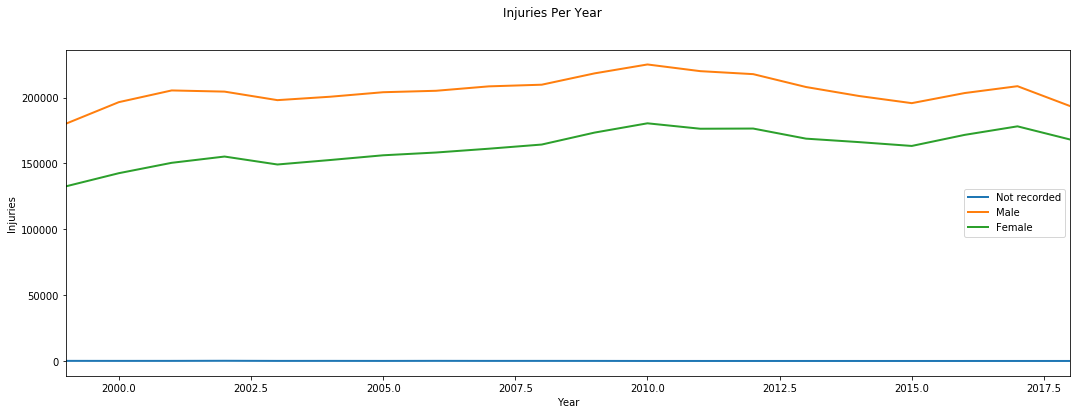

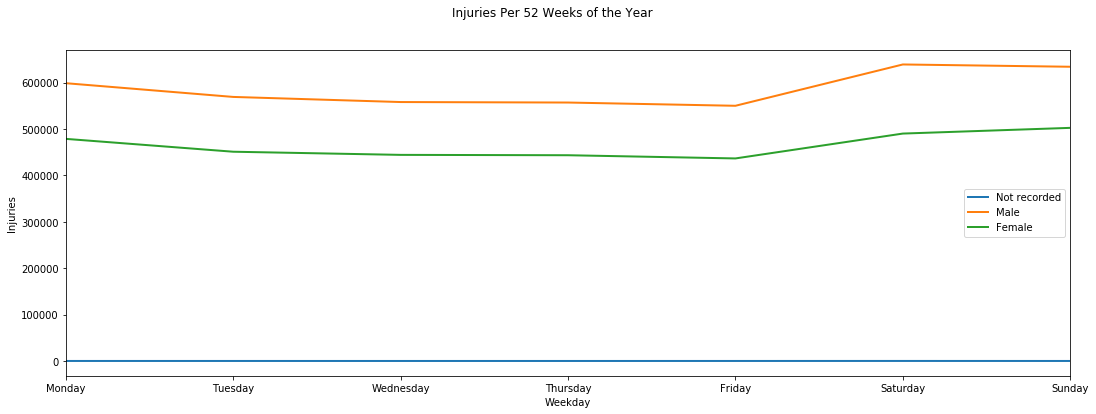

In [12]:
df = neiss.getDataFrame()
date_name, stat_name = 'Treatment_Date', 'Sex'

showInjuriesPerYear(df, date_name, stat_name, 'Injuries Per Year')
showInjuriesPerWeekOfTheYear(df, date_name, stat_name, 'Injuries Per 52 Weeks of the Year')
showInjuriesPerMonthOfTheYear(df, date_name, stat_name, 'Injuries Per Month of the Year')
showInjuriesPerWeekOfTheYear(df, date_name, stat_name, 'Injuries Per Week of the Year')
